# LinkNet: нейронная сеть для семантической сегментации изображений

Abhishek Chaurasia, Eugenio Culurciello, Jun 2017, https://arxiv.org/abs/1707.03718

Воспользуемся LinkNet для сегментации изображений $128 \times 128$, в которых в случайном месте располагается изображение MNIST $28 \times 28$ и добавлен шум из обрезков других картинок из базы.

In [1]:
import sys
import os
import numpy as np
import tensorflow as tf
import pickle
from tqdm import tqdm_notebook as tqm
from time import time
import math

import matplotlib.pyplot as plt

sys.path.append(os.path.join('..','..'))

from az_training.dataset import Dataset, DatasetIndex
from az_training.task_02.linknet import LinkNetBatch
from az_training.task_02.plot_functions import plot_example_interactive, plot_examples

%matplotlib inline

In [2]:
MNIST_SIZE = 65000
BATCH_SIZE = 512
MAX_ITER = 300

In [3]:
# создадим индекс и датасет для построения пайплайна

ind = DatasetIndex(np.arange(MNIST_SIZE))
mnistset = Dataset(ind, batch_class=LinkNetBatch)
mnistset.cv_split([0.9, 0.1])

In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [5]:
prediction = []
test_loss = []
train_loss = []

In [6]:
# пайплайны для обучения и контроля

level = 1
n_fragments = 80
size = 8
distr = 'uniform'

ppl = mnistset.train.pipeline()\
        .load_images()\
        .random_location() \
        .create_mask()\
        .add_noise('mnist_noise', level, n_fragments, size, distr)\
        .train(sess)\
        .get_stat(sess, train_loss, True)\
        
ppl_test = mnistset.test.pipeline()\
            .load_images()\
            .random_location() \
            .create_mask()\
            .add_noise('mnist_noise', level, n_fragments, size, distr)

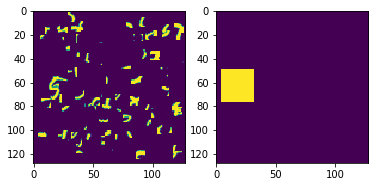

In [7]:
images = []
masks = []
ppl_test.get_images(images, masks).next_batch(100, n_epochs=None)
plt.subplot(121)
plt.imshow(images[0][0])
plt.subplot(122)
plt.imshow(masks[0][0])
plt.show()

In [ ]:
# обучение

start = time()
for i in range(MAX_ITER):
    ppl.next_batch(BATCH_SIZE, n_epochs=None)
    ppl_test.get_stat(sess, test_loss, False).next_batch(100, n_epochs=None)
    if (i+1) % 10 == 0:
        print("Iter {}: Train loss: {}, test loss: {}".format(i+1, train_loss[-1], test_loss[-1]))
stop = time()
print("Train time: {} min".format((stop-start)/60))

Iter 10: Train loss: 0.5718832612037659, test loss: 0.5636698007583618


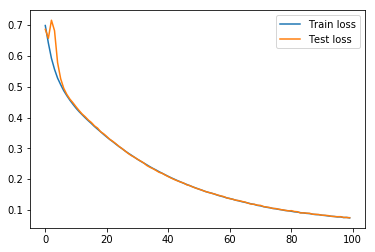

In [8]:
plt1, = plt.plot(train_loss,  label='Train loss')
plt2, = plt.plot(test_loss, label='Test loss')
plt.legend(handles=[plt1, plt2])
plt.show()

In [10]:
with open('with_bn.pkl', 'wb') as file:
    pickle.dump([train_loss, test_loss], file, pickle.HIGHEST_PROTOCOL)

In [15]:
with open('with_bn.pkl', 'rb') as file:
    a, b = pickle.load(file)

In [9]:
prediction = []
images = []
masks = []
ppl_test.get_images(images, masks)\
        .predict_proba(sess, prediction).next_batch(10, n_epochs=None)

In [12]:
with open('predictions128.pkl', 'wb') as output:
    pickle.dump([prediction, images, masks], output, pickle.HIGHEST_PROTOCOL)

In [3]:
with open('predictions128.pkl', 'rb') as inp:
    prediction, images, masks = pickle.load(inp)

In [ ]:
plot_examples(images, masks, prediction)